In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/convolve-epoch1/sample_submission.csv
/kaggle/input/convolve-epoch1/train.json
/kaggle/input/convolve-epoch1/test.csv


In [2]:
import re
from imblearn.under_sampling import RandomUnderSampler
import nltk
import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [3]:
df = pd.read_json('/kaggle/input/convolve-epoch1/train.json', typ='series')
raw_data = df.to_frame()
raw_data.reset_index(inplace=True)
raw_data.columns=['Logs', 'y']
raw_data.head()

,Logs,y
0,1117838570 2005.06.03 R02-M1-N0-C:J12-U11 200...,normal
1,1117838570 2005.06.03 R02-M1-N0-C:J12-U11 200...,normal
2,1117838570 2005.06.03 R02-M1-N0-C:J12-U11 200...,normal
3,1117838570 2005.06.03 R02-M1-N0-C:J12-U11 200...,normal
4,1117838570 2005.06.03 R02-M1-N0-C:J12-U11 200...,normal


In [4]:
def preprocess_text(sen):
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    sentence = sentence.replace('\n', ' ')
    sentence = sentence.lower()
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', sentence)
    sentence = sentence.replace('ras kernel', ' ').strip()
    return sentence

In [5]:
raw_data['y'] = raw_data['y'].apply(lambda x: 1 if x == 'normal' else 0)

In [6]:
X = raw_data.drop(['y'], axis = 1)
y = raw_data['y']

In [7]:
rus = RandomUnderSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y)

In [8]:
X_res['Logs'] = X_res['Logs'].apply(preprocess_text)

In [9]:
X_res

,Logs
0,ras app fatal ciod failed to read message pref...
1,ras app fatal ciod failed to read message pref...
2,ras app fatal ciod failed to read message pref...
3,ras app fatal ciod failed to read message pref...
4,ras app fatal ciod failed to read message pref...
...,...
139379,na na info generating core
139380,info generating core
139381,info instruction cache parity error corrected
139382,info generating core


In [10]:
X_res = list(X_res['Logs'])
X_res

['ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'nc nc ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'nc nc ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'ras app fatal ciod failed to read message prefix on control stream ciostream socket to',
 'ras app fatal ciod failed to read message prefix on control stream ciostream

In [11]:
type(y)

pandas.core.series.Series

In [12]:
y_res = np.array(list(y_res))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42)
len(X_train)

104538

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

len(X_train)

104538

In [15]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
len(X_train)

104538

In [16]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [17]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
import tensorflow as tf

In [19]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)

model.add(keras.layers.Lambda(lambda x: keras.backend.sum(x, axis=1)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(0.01)))

2022-12-20 06:04:34.600891: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          114000    
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 114,101
Trainable params: 114,101
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

2022-12-20 06:04:42.039625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
654/654 [==============================] - 5s 7ms/step - loss: 0.1617 - acc: 0.9912 - val_loss: 0.0969 - val_acc: 0.9996
Epoch 2/6
654/654 [==============================] - 4s 6ms/step - loss: 0.0716 - acc: 0.9998 - val_loss: 0.0492 - val_acc: 0.9999
Epoch 3/6
654/654 [==============================] - 4s 7ms/step - loss: 0.0317 - acc: 0.9998 - val_loss: 0.0184 - val_acc: 0.9999
Epoch 4/6
654/654 [==============================] - 4s 6ms/step - loss: 0.0129 - acc: 0.9996 - val_loss: 0.0102 - val_acc: 0.9995
Epoch 5/6
654/654 [==============================] - 4s 6ms/step - loss: 0.0098 - acc: 0.9997 - val_loss: 0.0093 - val_acc: 0.9999
Epoch 6/6
654/654 [==============================] - 4s 6ms/step - loss: 0.0091 - acc: 0.9998 - val_loss: 0.0087 - val_acc: 0.9999


In [22]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1089/1089 [==============================] - 2s 2ms/step - loss: 0.0087 - acc: 0.9999
Test Score: 0.008736198768019676
Test Accuracy: 0.9998565316200256


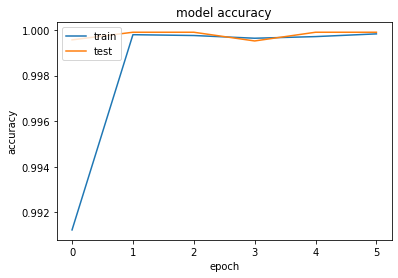

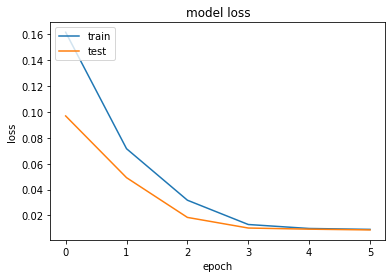

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [24]:
test_data = pd.read_csv('/kaggle/input/convolve-epoch1/test.csv')
test_data

,ID,Log
0,0,1124336301 2005.08.17 R13-M1-N8-C:J12-U01 200...
1,1,1118553175 2005.06.11 R30-M0-N9-C:J16-U01 200...
2,2,1118536033 2005.06.11 R30-M0-N9-C:J16-U01 200...
3,3,1117992566 2005.06.05 R30-M1-N6-C:J03-U11 200...
4,4,1118538965 2005.06.11 R30-M0-N9-C:J16-U01 200...
...,...,...
595295,595295,1118768234 2005.06.14 R20-M0-NA-C:J17-U11 200...
595296,595296,1118370947 2005.06.09 R15-M0-NA-C:J02-U01 200...
595297,595297,1118540242 2005.06.11 R30-M0-N9-C:J16-U01 200...
595298,595298,1118538947 2005.06.11 R30-M0-N9-C:J16-U01 200...


In [25]:
X_test_real = test_data.drop(['ID'], axis = 1)
X_test_real.shape

(595300, 1)

In [26]:
X_test_real[' Log'] = X_test_real[' Log'].apply(preprocess_text)

In [27]:
X_test_real.shape

(595300, 1)

In [28]:
X_test_real = list(X_test_real[' Log'])
len(X_test_real)

595300

In [29]:
X_test_real = tokenizer.texts_to_sequences(X_test_real)
len(X_test_real)

595300

In [30]:
X_test_real = pad_sequences(X_test_real, padding='post', maxlen=maxlen)

In [31]:
len(X_test_real)

595300

In [32]:
y_pred = model.predict(X_test_real)

In [33]:
y_pred

array([[0.9591469 ],
       [0.00146005],
       [0.00146005],
       ...,
       [0.00146005],
       [0.00146005],
       [0.99987435]], dtype=float32)

In [34]:
y_classes = y_pred > 0.5

In [35]:
y_classes

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [36]:
test_data

,ID,Log
0,0,1124336301 2005.08.17 R13-M1-N8-C:J12-U01 200...
1,1,1118553175 2005.06.11 R30-M0-N9-C:J16-U01 200...
2,2,1118536033 2005.06.11 R30-M0-N9-C:J16-U01 200...
3,3,1117992566 2005.06.05 R30-M1-N6-C:J03-U11 200...
4,4,1118538965 2005.06.11 R30-M0-N9-C:J16-U01 200...
...,...,...
595295,595295,1118768234 2005.06.14 R20-M0-NA-C:J17-U11 200...
595296,595296,1118370947 2005.06.09 R15-M0-NA-C:J02-U01 200...
595297,595297,1118540242 2005.06.11 R30-M0-N9-C:J16-U01 200...
595298,595298,1118538947 2005.06.11 R30-M0-N9-C:J16-U01 200...


In [37]:
raw_data.tail()

,Logs,y
4152654,1118545530 2005.06.11 R30-M0-N9-C:J16-U01 2005...,0
4152655,1118545530 2005.06.11 R30-M0-N9-C:J16-U01 2005...,0
4152656,1118545530 2005.06.11 R30-M0-N9-C:J16-U01 2005...,0
4152657,1118545530 2005.06.11 R30-M0-N9-C:J16-U01 2005...,0
4152658,1118545530 2005.06.11 R30-M0-N9-C:J16-U01 2005...,0


In [38]:
test_data[" Label"] = np.select([y_classes], ["normal"], default="abnormal")
test_data

,ID,Log,Label
0,0,1124336301 2005.08.17 R13-M1-N8-C:J12-U01 200...,normal
1,1,1118553175 2005.06.11 R30-M0-N9-C:J16-U01 200...,abnormal
2,2,1118536033 2005.06.11 R30-M0-N9-C:J16-U01 200...,abnormal
3,3,1117992566 2005.06.05 R30-M1-N6-C:J03-U11 200...,normal
4,4,1118538965 2005.06.11 R30-M0-N9-C:J16-U01 200...,abnormal
...,...,...,...
595295,595295,1118768234 2005.06.14 R20-M0-NA-C:J17-U11 200...,normal
595296,595296,1118370947 2005.06.09 R15-M0-NA-C:J02-U01 200...,normal
595297,595297,1118540242 2005.06.11 R30-M0-N9-C:J16-U01 200...,abnormal
595298,595298,1118538947 2005.06.11 R30-M0-N9-C:J16-U01 200...,abnormal


In [39]:
len(y_classes)

595300

In [40]:
len(test_data)

595300

In [41]:
X_test_real.shape

(595300, 100)

In [42]:
X_train.shape

(104538, 100)

In [43]:
y_train.shape

(104538,)

In [44]:
final_submission = test_data.drop(' Log', axis=1)
final_submission

,ID,Label
0,0,normal
1,1,abnormal
2,2,abnormal
3,3,normal
4,4,abnormal
...,...,...
595295,595295,normal
595296,595296,normal
595297,595297,abnormal
595298,595298,abnormal


In [ ]:
test_data.to_csv('reference_last.csv')
final_submission.to_csv('to_be_submitted_real_8.csv', index=False)